In [1]:
# nuclio: ignore
import nuclio

In [2]:
%nuclio config kind = "job"
%nuclio config spec.image = "mlrun/ml-models"

%nuclio: setting kind to 'job'
%nuclio: setting spec.image to 'mlrun/ml-models'


In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [4]:
import os
import pandas as pd
from mlrun.datastore import DataItem
from mlrun.artifacts import get_model

In [5]:
def _eval_model(context, xtest, ytest, model, score_method="micro", plots_dest="plots"):
    """internal evaluate one model
    """
    from sklearn import metrics
    from cloudpickle import load
    import matplotlib.pyplot as plt
    from sklearn.preprocessing import label_binarize
    from sklearn.utils.multiclass import unique_labels
    from mlrun.artifacts import PlotArtifact
    from mlrun.mlutils import plot_roc, feature_importances, gcf_clear

    # enclose all except model
    ytestb = label_binarize(ytest, classes=ytest.unique())
    
    context.header = xtest.columns.names
    
    clf = load(open(model, "rb"))
    if callable(getattr(clf, "predict_proba")):
        y_score = clf.predict_proba(xtest.values, validate_features=False)
        ypred = clf.predict(xtest.values, validate_features=False)
        plot_roc(context, ytestb, y_score, key='roc', plots_dir="plots")
    else:
        ypred = clf.predict(xtest.values, validate_features=False) # refactor
        y_score = None

    gcf_clear(plt)
    metrics.plot_confusion_matrix(clf, xtest, ytest, 
                                  labels=ytest.unique(), normalize='true') 
    
    context.log_artifact(PlotArtifact("confusion", body=plt.gcf()), 
                         artifact_path_path=f"{model.split('.')[-2]}-confusion.html") 
    
    if hasattr(clf, "feature_importances_"):
        plot, tbl = feature_importances(clf, list(xtest.columns))
        context.log_artifact(plot, local_path="plots/feature-importances.html")
        context.log_artifact(tbl, local_path="plots/feature-importances-table.csc")

    ytestb = label_binarize(ytest, classes=ytest.unique())

    if ytestb.shape[1] > 1:
        average_precision = metrics.average_precision_score(ytestb,
                                                            y_score,
                                                            average=score_method)
        context.log_result(f"rocauc", metrics.roc_auc_score(ytestb, y_score))
    else:
        average_precision = metrics.average_precision_score(ytestb,
                                                            y_score[:, 1],
                                                            average=score_method)
        context.log_result(f"rocauc", metrics.roc_auc_score(ytestb, y_score[:, 1]))

    context.log_result(f"avg_precscore", average_precision)
    context.log_result(f"accuracy", float(clf.score(xtest, ytest)))
    context.log_result(f"f1_score", metrics.f1_score(ytest, ypred,
                                                     average=score_method))
    if y_score is None:
        return y_score
    else:
        return ypred

In [6]:

def test_classifier(
    context,
    models_path: DataItem, 
    test_set: DataItem,
    label_column: str,
    score_method: str = 'micro',
    plots_dest: str = "plots",
    model_evaluator = None
) -> None:
    """Test one or more classifier models against held-out dataset
    
    Using held-out test features, evaluates the peformance of the estimated model
    
    Can be part of a kubeflow pipeline as a test step that is run post EDA and 
    training/validation cycles
    
    :param context:         the function context
    :param models_path:     artifact models representing a file or a folder
    :param test_set:        test features and labels
    :param label_column:    column name for ground truth labels
    :param score_method:    for multiclass classification
    :param plots_dest:      dir for test plots
    :param model_evaluator: NOT IMPLEMENTED: specific method to generate eval, passed in as string
                            or available in this folder
    """
    xtest = test_set.as_df()
    ytest = xtest.pop(label_column)
    
    model_file, model_obj, _ = get_model(models_path, suffix='.pkl')
    
    # there could be different eval_models, type of model (xgboost, tfv1, tfv2...)
    # or how probabilities are calculated, etc...
    if not model_evaluator:
        # binary and multiclass
        y_hat = _eval_model(context, xtest, ytest, model_file, 
                            score_method,
                            plots_dest or 'plots')

    # give the prediction columns titles/headers
    if y_hat.ndim == 1 or y_hat.shape[1] == 1:
        score_names = ["yscore"]
    else:
        score_names = ["yscore_" + str(x) for x in range(y_hat.shape[1])]

    # log the test set and its predictions (should also bind model and metadata)
    df = pd.concat([xtest, ytest, pd.DataFrame(y_hat, columns=score_names)], axis=1)
    context.log_dataset("test_set_preds", df=df, format="parquet", index=False)

In [7]:
# nuclio: end-code

### mlconfig

In [8]:
from mlrun import mlconf
import os

mlconf.dbpath = mlconf.dbpath or 'http://mlrun-api:8080'
mlconf.artifact_path = mlconf.artifact_path or f'{os.environ["HOME"]}/artifacts'

### save

In [9]:
from mlrun import code_to_function 
# create job function object from notebook code
fn = code_to_function("test_classifier")

# add metadata (for templates and reuse)
fn.spec.default_handler = "test_classifier"
fn.spec.description = "test a classifier using held-out or new data"
fn.metadata.categories = ["ml", "test"]
fn.metadata.labels = {"author": "yjb", "framework": "sklearn"}
fn.export("function.yaml")

[mlrun] 2020-05-15 10:21:25,602 function spec saved to path: function.yaml


## tests

In [10]:
if "V3IO_HOME" in list(os.environ):
    from mlrun import mount_v3io
    fn.apply(mount_v3io())
else:
    # is you set up mlrun using the instructions at https://github.com/mlrun/mlrun/blob/master/hack/local/README.md
    from mlrun.platforms import mount_pvc
    fn.apply(mount_pvc('nfsvol', 'nfsvol', '/home/jovyan/data'))

In [11]:
task_params = {
    "name" : "tasks - test classifier",
    "params": {
        # Ina pipeline setting, the models_path parameter would be the output of a training step
        "models_path"   : mlconf.artifact_path + "/models",
        "label_column"  : "labels",
        "plots_dest"    : mlconf.artifact_path + "/plots"}}

### run locally

In [12]:
DATA_URL = "https://raw.githubusercontent.com/yjb-ds/testdata/master/data/test_set.parquet"

[mlrun] 2020-05-15 10:21:25,650 warning!, server (0.4.7) and client (0.4.8) ver dont match
[mlrun] 2020-05-15 10:21:25,651 starting run tasks - test classifier uid=05a50e19f3de41e08008d7426aa90fad  -> http://mlrun-api:8080
[mlrun] 2020-05-15 10:21:25,670 warning!, server (0.4.7) and client (0.4.8) ver dont match


No handles with labels found to put in legend.


[mlrun] 2020-05-15 10:21:27,008 log artifact roc at /User/artifacts/plots/roc.html, size: 15614, db: Y
[mlrun] 2020-05-15 10:21:27,165 log artifact confusion at /User/artifacts/confusion, size: 9856, db: Y
[mlrun] 2020-05-15 10:21:27,416 log artifact feature-importances at /User/artifacts/plots/feature-importances.html, size: 14790, db: Y
[mlrun] 2020-05-15 10:21:27,498 log artifact feature-importances-tbl at /User/artifacts/plots/feature-importances-table.csc, size: 120, db: Y
[mlrun] 2020-05-15 10:21:27,591 log artifact test_set_preds at /User/artifacts/test_set_preds.parquet, size: 5129, db: Y



project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
default,...6aa90fad,0,May 15 10:21:25,completed,tasks - test classifier,v3io_user=adminkind=handlerowner=adminhost=jupyter-f597579bb-l8hbz,test_setmodels_path,models_path=/User/artifacts/modelslabel_column=labelsplots_dest=/User/artifacts/plots,rocauc=0.0avg_precscore=0.35082132521761006accuracy=0.96f1_score=0.96,rocconfusionfeature-importancesfeature-importances-tbltest_set_preds


to track results use .show() or .logs() or in CLI: 
!mlrun get run 05a50e19f3de41e08008d7426aa90fad --project default , !mlrun logs 05a50e19f3de41e08008d7426aa90fad --project default
[mlrun] 2020-05-15 10:21:27,681 run executed, status=completed


<Figure size 432x288 with 0 Axes>

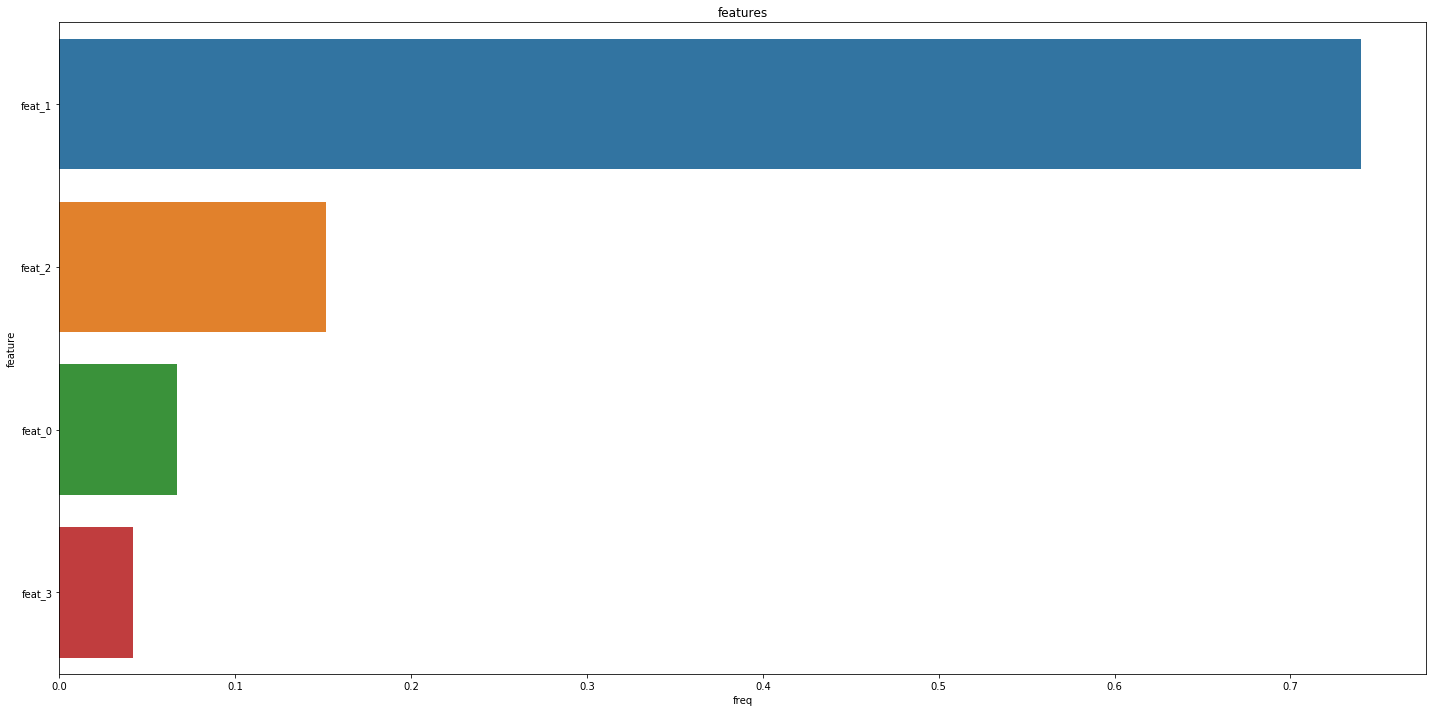

In [13]:
from mlrun import run_local, NewTask

run = run_local(NewTask(**task_params),
                handler=test_classifier,
                inputs={"test_set": "/User/artifacts/test_set.parquet",
                        "models_path": "models"},
                workdir=mlconf.artifact_path)

### remotely

In [ ]:
from mlrun import NewTask
run = fn.run(NewTask(**task_params), 
             inputs={"test_set": "/User/artifacts/test_set.parquet",
                        "models_path": "models"},
             workdir="/User/artifacts")

[mlrun] 2020-05-15 10:22:30,920 starting run tasks - test classifier uid=3492b3c9ba214c07a386f30ae11042aa  -> http://mlrun-api:8080
[mlrun] 2020-05-15 10:22:31,024 Job is running in the background, pod: tasks---test-classifier-25j8t
[mlrun] 2020-05-15 10:22:34,488 warning!, server (0.4.7) and client (0.4.8) ver dont match
[mlrun] 2020-05-15 10:22:34,505 warning!, server (0.4.7) and client (0.4.8) ver dont match
No handles with labels found to put in legend.
[mlrun] 2020-05-15 10:22:36,083 log artifact roc at /User/artifacts/plots/roc.html, size: 30886, db: Y
[mlrun] 2020-05-15 10:22:36,261 log artifact confusion at /User/artifacts/confusion, size: 19220, db: Y
[mlrun] 2020-05-15 10:22:36,544 log artifact feature-importances at /User/artifacts/plots/feature-importances.html, size: 28218, db: Y
[mlrun] 2020-05-15 10:22:36,562 log artifact feature-importances-tbl at /User/artifacts/plots/feature-importances-table.csc, size: 120, db: Y
[mlrun] 2020-05-15 10:22:36,625 log artifact test_set_